In [1]:
#!/bin/env python3
# this script will download precip and temp data from NWS ACIS
import logging
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import cwms
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
# load .env python environment for storing API_KEY
# .env file can be stored a parent directory of script
# https://dev.to/jakewitcher/using-env-files-for-environment-variables-in-python-applications-55a1
from dotenv import load_dotenv
import os
import requests
import json

In [2]:
def dataObjectToDf(dataObject):
    if type(dataObject) == cwms.types.Data:
        units = dataObject.json['units']
        name = dataObject.json['name']  
        df = dataObject.df    
        return df, name, units
    elif type(dataObject) == dict:
        units = dataObject['units']
        name = dataObject['name']         
        df = pd.DataFrame(dataObject['values'], columns  = ['date-time', 'value', 'quality-code']) 
        #cast date-time column to datetime object
        df["date-time"] = pd.to_datetime(df["date-time"])
        return df, name, units
    else:
        print('Error converting data object to dataframe, name, and units')
        return None, None, None

In [3]:
# grab API variables from .env file
load_dotenv()
APIROOT = os.getenv("API_ROOT")
OFFICE = os.getenv("OFFICE")
APIKEY = os.getenv('API_KEY')
# connect to T7
apiKey = "apikey " + APIKEY
api = cwms.api.init_session(api_root=APIROOT, api_key=apiKey)

In [4]:
# days back to get data
lookbackDays = 10
# hrs offset to store values...default 12z
hourOffset = 12
#acis url
url = 'https://data.rcc-acis.org/StnData'
# acis elements
elems = [
    {"name":"pcpn"}, 
    {"name":"snow"}, 
    {"name":"snwd"}, 
    {"name":"maxt"}, 
    {"name":"mint"}, 
    {"name":"obst"},
    {"vX":13}
    #{"vX":28 },
    #{"vX":27 }
      
]
#ts version to save as
version = 'Raw-NWS-ACIS'
# ts element to ts_id mapping
tsMapping = {"pcpn":f"Precip.Total.~1Day.1Day.{version}", 
    "snow":f"Depth-Inc-Snow.Total.~1Day.1Day.{version}", 
    "snwd":f"Depth-Snow.Total.~1Week.1Month.{version}", 
    "maxt":f"Temp-Air.Max.~1Day.1Day.{version}", 
    "mint":f"Temp-Air.Min.~1Day.1Day.{version}", 
    "obst":f"Temp-Air.Inst.~1Day.0.{version}",
    13:f"Depth-SWE.Total.~1Week.1Month.{version}"
    #28:f"Speed-Wind.Inst.~1Day.0.{version}",
    #27:f"Dir-Wind.Inst.~1Day.0.{version}"
}
#unit mapping  
unitMapping = {"pcpn":"in", 
    "snow":"in", 
    "snwd":"in", 
    "maxt":"F", 
    "mint":"F", 
    "obst":"F",
    13:"in",
    #28:"mph",
    #27:"deg"  
              }
#missing value in CWMS
cwms_missing_value = -340282346638528859811704183484516925440
cwms_missing_quality = 5

# create list of column names
cols =  [d[list(d.keys())[0]] for d in elems]
# add date-time as column
cols.insert(0, 'date-time')

# You need to make a NWS ACIS Project group...this triggers what data to get
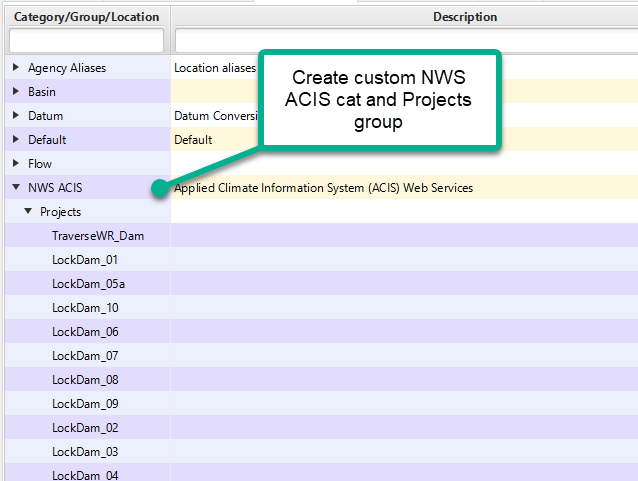

In [5]:
# build start date and end date
sdate = (datetime.now()-timedelta(days=lookbackDays)).strftime("%Y-%m-%d")
edate = datetime.now().strftime("%Y-%m-%d")
print(sdate, edate)

2024-10-15 2024-10-25


In [6]:
# get CWMS locations in MVP NWS ACIS Project group...this triggers what data to get
df_loc_data = cwms.get_location_group(category_id="NWS ACIS",loc_group_id="Projects",office_id=OFFICE).df
# get NWS aliases
df_loc_nws = cwms.get_location_group(category_id="Agency Aliases", loc_group_id="NWS Handbook 5 ID",office_id="CWMS").df

In [7]:
# merge CWMS locations in ACIS project group with NWS aliases
nws_alias = pd.merge(df_loc_data, df_loc_nws, on='location-id').set_index('location-id')
nws_alias

,office-id_x,attribute_x,office-id_y,alias-id,attribute_y
location-id,,,,,
TraverseWR_Dam,MVP,0.0,MVP,WHRM5,0.0
EauGalle_Dam,MVP,NaN,MVP,SVPW3,0.0
MissHW_Winni,MVP,NaN,MVP,WNBM5,0.0
MissHW_PineRiver,MVP,NaN,MVP,CRLM5,0.0
LacQuiParle_Dam,MVP,NaN,MVP,LAQM5,0.0
MissHW_Gull,MVP,NaN,MVP,GLLM5,0.0
LowerSAFalls,MVP,NaN,MVP,LSAM5,0.0
RedLake_Dam,MVP,NaN,MVP,RRDM5,0.0
MissHW_Pokegama,MVP,NaN,MVP,PKGM5,0.0


In [8]:
# walk through locations
for index, row in nws_alias.iterrows():
    loc = index
    #if loc == 'LockDam_02':
    nws_id = row['alias-id']
    print(loc, nws_id)
    input_dict = {
        "sid":nws_id,
        "sdate":sdate,
        "edate":edate,
        "elems":elems,
    }
    params = {'params': json.dumps(input_dict)}
    headers = {'Accept': 'application/json'}
    # get data
    req = requests.post(url, data=params, headers=headers)
    response = req.json()
    try:
        acis_data = response['data']
        # convert to pandas dataframe
        df = pd.DataFrame(acis_data, columns = cols)
        #standardize to typical entry time
        df["date-time"] = pd.to_datetime(df["date-time"])+ pd.Timedelta(hours=hourOffset)
        # walk through each of the parameter columns, skipping date-time column
        for param in cols[1::]:
            
            #get units from unit mapping dict
            units = unitMapping[param]
            
            # create subset of dataframe with just one parameter
            d = df[['date-time', param ]].copy()
            # set quality code
            d.loc[:,'quality-code'] = 0
            # rename columns
            d.columns = ['date-time', 'value', 'quality-code']
            #drop missing values
            d = d[d['value'] != 'M']
            #change trace flag to .001
            d['value'] = d['value'].replace('T', str(0.001))
            #change S flag to missing
            d['value'] = d['value'].replace('S', cwms_missing_value)
            # set missing qualifier
            d.loc[d['value'] == cwms_missing_value, 'quality-code'] = cwms_missing_quality
            # Screen out A flag which is paired w/ S flag to signify a multiday total
            d['value'] = d['value'].replace(r'[^0-9\.]', '', regex=True)
            # assign timeseries id from mapping dictionary
            ts_id = f'{loc}.{tsMapping[param]}'

            #convert to json
            data_json = cwms.timeseries_df_to_json(data = d, 
                                               ts_id = ts_id, units = units, office_id = OFFICE)
            #print(data_json)
            #store data
            cwms.store_timeseries(data=data_json)
    except:
        print(f'error retrieving data from {loc}')        

    

TraverseWR_Dam WHRM5
EauGalle_Dam SVPW3
MissHW_Winni WNBM5
MissHW_PineRiver CRLM5
LacQuiParle_Dam LAQM5
error retrieving data from LacQuiParle_Dam
MissHW_Gull GLLM5
LowerSAFalls LSAM5
RedLake_Dam RRDM5
MissHW_Pokegama PKGM5
MissHW_Leech FEDM5
MissHW_Sandy SDYM5
LockDam_01 SPAM5
Baldhill_Dam BLDN8
LockDam_03 RDWM5
LockDam_04 ALMW3
LockDam_05 MSCM5
LockDam_05a WIDM5
LockDam_06 TREW3
LockDam_07 LCRM5
LockDam_08 GENW3
LockDam_09 LYNW3
LockDam_10 GTTI4
LakeDarling_Dam DARN8
ChippewaDiv_Dam WTSM5
Orwell_Dam ORWM5
TraverseRES_Dam TRAM5
LockDam_02 HSTM5
